In [88]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import qpcr._auxiliary as aux
import qpcr._auxiliary.Qlipper as auxQ


In [89]:
class _CORE(aux._ID):
    """
    The functional core class that handles the common methods of Qlipper classes.
    """
    def __init__(self):
        self._src = None # the data source (filepath, or streamlit UploadedFile) 
        self._raw = None # the raw data
        self._data = None # the processed and transformed data used for computation...
        self._final = None # the df for the computed Ct values
        self._absmax, self._absmin = None, None # max and min absorption values

    def getlim(self):
        """
        Returns the min and max absorption values from the data
        """
        return self._absmin, self._absmax

    def Ct(self, threshold = "best", round = 4, use_nan = False, mean_range = 0):
        """
        Infers Ct values based on upsampled data, using a specified threshold.

        Parameters
        ----------
        
        threshold : str or float
            The threshold set for Ct values. This may be either `"best"` or a `float`.
            If `threshold = "best"` is set, the best threshold will be computed based on $\sum R^2$ for all absorption curves.
            See the documentation of `best_threshold()` for more details. Note, that using the `"best"` setting will run 
            `best_threshold()` under default settings. If alternative settings are desired, please, run `best_threshold()` separately,
            and supply the returned threshold directly.
        
        round : int
            Round the Ct to `round` digits (default is `round = 4`)

        use_nan : bool
            Sets the index to `np.nan` if no intersect can be found if True.
            Default is `use_nan = False` in which case the max possible index is 
            arbitrarily assigned.

        mean_range : int
            Given the inferential nature of assigning the Ct value, the user may specify
            a range of indices around the found "best match" to include and average the upsampled
            Cts from these. This averaged Ct value will ultimately be reported. By default this is 
            disabled by `mean_range = 0` (i.e. only use the best match itself). Note that the integer
            count will be applied symettrically to both sides (if possible), so a `mean_range = 2` would 
            result in a range of `idx-2 , idx-1, idx, idx+1, idx+2`, wehre `idx` is the best matching index.

        Returns
        -------
        new : pd.DataFrame
            A pandas Dataframe containing the computed Ct values.
        """

        data = self._data
        columns = data.columns
        new = pd.DataFrame(dict(sample = [], Ct = []))

        threshold = self.best_threshold() if threshold == "best" else threshold

        for col in columns:

            abs_data = data[col][1]
            cycles = data[col][0]
            
            # make threshold line
            tline = np.tile([threshold], len(abs_data))

            # get intersect index of tline and abs_data
            idx = auxQ.get_intersect(abs_data, tline, use_nan = use_nan)

            # get Ct
            Ct = self._infer_Ct(round, mean_range, cycles, idx)

            # store new data
            _new = pd.DataFrame(dict(sample = [col], Ct = [Ct]))
            new = pd.concat([new, _new], axis = 0)
        
        # store final results
        self._final = new
        return new

    def best_threshold(self, steps = 200, window_size = 0.1):
        """
        Infers the best threshold for the given absorption curves.
        This function applies slides in `steps` steps from the minimal to maximal measured absorption
        and applies a window of size `window_size` around each intersecting index of each curve for a given
        potential threshold. Subsequently, it uses $R^2$ to determine linearity of each curve at the given 
        intersecting index. $R^2$ values for each potetial threshold are accumulated and the overall index where
        $\sum R^2$ is maximized is returned as best threshold.

        Parameters
        ----------
        steps : int
            The number of steps the threshold slider shall perform while finding the best threshold. 
            Default is `steps = 200`.
        
        window_size : int or float
            The window size around each intersecting index of each curve to include in $R^2$ computation.
            If this value is a `float` $\in [0,1]$ then it will be interpreted as fraction of the total length
            of upsampled data points. Hence, `window_size = 0.1` represents a window-size that includes 10% of all 
            upsampled data points, while `window_size = 20` represents a window-size that includes exactly 20 data points.

        Returns
        -------
        threshold : float
            The threshold where $\sum R^2$ of all curves is maximized.
        """

        new = self._data
        columns = new.columns
        absmax, absmin = np.log(self._absmax), np.log(self._absmin)

        # how many steps should the slider take while sliding over the absorption values
        slider = np.linspace(absmin, absmax, num = steps) 
        # an array to save the r_squared values to later on...
        r_squares = np.zeros(steps)

        # size of the window ranges
        window_size = self._infer_window_size(window_size, new, columns)

        tdx = 0 # a counting index for the thresholds
        for t in slider:
            # get R^2 for each curve for the given threshold t
            for col in columns:

                # get the upsampled absorption data
                abs_data = new[col][2]
                # generate a threshold line
                tline = np.tile([t], len(abs_data))
                
                # get the intersecting index
                idx = auxQ.get_intersect(abs_data, tline)
                
                # generate window-range
                abs_range_values, cycle_range_values = self._generate_window_range(window_size, abs_data, idx)

                # compute R^2
                line_stats = stats.linregress(x = cycle_range_values, y = abs_range_values)
                r = line_stats[2]
                r_squared = r ** 2
                # store R^2
                r_squares[tdx] += r_squared
            
            tdx += 1

        # now get the best threshold
        best_idx = np.argwhere(r_squares == r_squares.max())
        
        threshold = float(slider[best_idx])
        return threshold

    def _generate_window_range(self, window_size, abs_data, idx):
        """
        Returns two np.ndarrays of absorption values and corresponding cycles
        from upsampled data based on the window size and supplied intersection index.
        """
        start = np.max((0,idx-window_size))
        stop = np.min((len(abs_data), idx+window_size))
        window_range = slice(start, stop)

        # get data values in window-range
        abs_range_values = abs_data[window_range]
        cycle_range_values = np.arange(start, stop)

        return abs_range_values,cycle_range_values

    def _infer_window_size(self, window_size, new, columns):
        """
        Infers the linreg window size for R^2, either taking the fraction of 
        all data points if window_size <= 1 or the provided integer number
        """
        return int(window_size * new[columns[0]][1].size) if window_size <= 1.0 else window_size


    def _infer_Ct(self, round, mean_range, cycles, idx):
        """
        Gets the final reported Ct from the intersecting index.
        This function performs the final processing steps such as averaging
        and rounding, provided the user specified settings to that effect.
        """
        try: 
            mean_range_start = np.max((0, idx-mean_range-1))
            mean_range_stop = np.min((len(cycles), idx+mean_range))
            mean_range_cycles = slice(mean_range_start, mean_range_stop)
            mean_range_cycles = cycles[mean_range_cycles]
            Ct = np.nanmean(mean_range_cycles)
            Ct = np.round(Ct, round)
        except: 
            Ct = np.nan
        return Ct


    def _upsample(self):
        """
        Generates a new dataframe that stores for each data row (original curve data)
        both the data as well as corresponding cycle numbers (x-values), and then upsamples these.
        The final dataframe will contain a column for each curve containing two rows (first the x-values, second the absorption vlaues).

        Returns
        -------
        new : pd.DataFrame
            A pandas dataframe containing the upsampled and re-arranged absorption values.
        """

        data = self._raw
        columns = data.columns
        new = None

        for col in columns:
            
            # get absorption values
            abs_data = data[col]
            # infer cycle numbers (since the first measurement is from the 1st cycle, we start at 1 instead of 0)
            cycles = np.arange(1, len(abs_data)+1)
            
            # upsample
            up_cycles, up_abs_data = auxQ.upsample_coords([cycles, abs_data])
            log_up_abs_data = np.log(up_abs_data)
            
            # assemble new data
            _new = pd.DataFrame({ col : [up_cycles, up_abs_data, log_up_abs_data]})

            # store new data
            if new is None: 
                new = _new
            else:
                new = new.merge(_new, left_index=True, right_index=True)
                
        return new

In [90]:

class Qlipper(_CORE):
    """
    Reads a file of raw absorption values and generates a table of `Ct` values.
    Currently supported input formats for absorption curves `csv` files of one named
    column for each measured transcript, and cycles as rows. 

    Parameters
    ----------
    filename : str
        A file path to a file containing absorption values. (optional, as this can be linked later using `link()`)
    """
    def __init__(self, filename : str = None):
        self._src = filename
        self._raw = None # the raw data
        self._data = None # the processed and transformed data used for computation...
        self._final = None # the df for the computed Ct values
        self._absmax, self._absmin = None, None # max and min absorption values

        if self._src is not None: 
            self.read(self._src)

    def get(self, which = "final"):
        """
        Returns
        -------
        data : pd.DataFrame
            A pandas dataframe containing either the raw absorption values (if `which = "raw"`),
            pre-processed (i.e. upsampled) absorption values used for analysis and visualisation
            (if `which = "prep"`), or the final Ct values (if `which = "final"`, default).
        """
        datas = {
            "raw" : self._raw,
            "prep" : self._data,
            "final" : self._final,
        }
        data = datas[which]
        return data

    def read(self, filename : str):
        """
        Reads a raw-data file.

        Parameters
        ----------
        filename : str
        A file path to a file containing absorption values.
        """

        _delimiter = ";" if self._is_csv2(filename) else ","
        _header = self._has_header(filename)

        # read raw data
        self._raw = pd.read_csv(
                                filename, 
                                sep = _delimiter, 
                                header = _header, 
                            )
        # get absorption max and min values
        self._absmax, self._absmin = self._raw.max().max(), self._raw.min().min()

        # and pre-process
        self._data = self._upsample()

    def _is_csv2(self, filename):
        """
        Tests if csv file is ; delimited (True) or common , (False)
        """
        try: 
            with open(filename, "r") as openfile: 
                content = openfile.read()
            if ";" in content: 
                return True
            return False
        except: 
            return False
    
    def _has_header(self, filename):
        """
        Checks if column headers are provided in the data file
        It does so by checking if the second element in the first row is numeric
        if it is numeric (returns None << False) no headers are presumed. Otherwise
        it returns 0 (as in first row has headers)...
        """
        _delimiter = ";" if self._is_csv2(filename) else ","
        try: 
            with open(filename, "r") as openfile: 
                content = openfile.read().split("\n")[0]
                content = content.split(_delimiter)
            try: 
                second_col = content[1]
                second_col = float(second_col)
            except ValueError:
                return 0 # Headers in row 0
            return None  # no headers
        except: 
            return 0

In [91]:
myfile = "./rex_data/rex_small.csv"

In [92]:
qlip = Qlipper(myfile)

In [93]:
qlip.best_threshold()

1.198046665351963

Alright, we will work some more on the inference of best efficiency... Witht his default linreg approach we get efficiency-slopes around 3, which seems a bit high...

We might have to perform log-transform for the data... Check the papers again for this..

/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_17357/804402542.py:26: RuntimeWarning: overflow encountered in double_scalars
  efficiencies[_idx] += -1 + 10 ** (-1 / slopes[_idx]) # this formula actually only applies to the log-transformed data...


{'whiskers': [<matplotlib.lines.Line2D at 0x127cea220>,
 'caps': [<matplotlib.lines.Line2D at 0x127cea7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x127ca9f10>,
 'medians': [<matplotlib.lines.Line2D at 0x127cead60>,
 'fliers': [<matplotlib.lines.Line2D at 0x127cf7070>,
 'means': []}

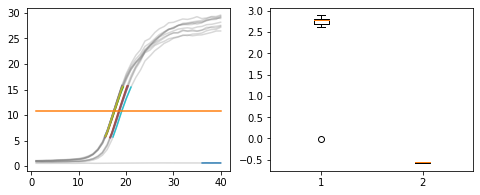

In [94]:
data = qlip.get("prep")

best_t = 10.750199459953318  # the best threshold (manually computed based on non-log-transformed data)
around = 0.1 # range around best index

columns = data.columns
length = len(data[columns[0]][1])
slopes = np.zeros(len(columns))
efficiencies = np.zeros(len(columns))

fig, axs = plt.subplots(1,2, figsize = (8,3))
_idx = 0
for col in columns:
    xvals_all, yvals_all, logs = data[col]
    tline = np.zeros(len(yvals_all))
    tline += best_t
    idx = auxQ.get_intersect(yvals_all, tline)
    xvals = xvals_all[
                    - int(around * length) + idx : int(around * length) + idx
                ]
    yvals = yvals_all[
                    - int(around * length) + idx : int(around * length) + idx
                ]
    line_stats = stats.linregress(x = xvals, y = yvals)
    slopes[_idx] += line_stats[0]
    efficiencies[_idx] += -1 + 10 ** (-1 / slopes[_idx]) # this formula actually only applies to the log-transformed data...
    axs[0].plot(xvals_all, yvals_all, c = "gray", alpha =.3)
    axs[0].plot(xvals, yvals, alpha = 0.9)
    _idx += 1

axs[0].plot(xvals_all, tline)
axs[1].boxplot([slopes, efficiencies])


In [95]:
np.median(efficiencies)

-0.5616290737392062

/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_17357/2671712125.py:26: RuntimeWarning: overflow encountered in double_scalars
  efficiencies[_idx] += 1 - 10**(-1 / slopes[_idx])


0.9989006599453839

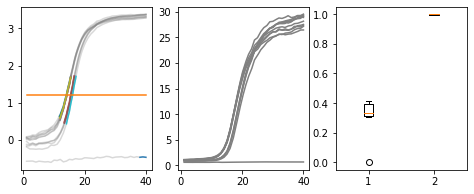

In [100]:
data = qlip.get("prep")

best_t = qlip.best_threshold()#+0.5  # the best threshold (manually computed based on non-log-transformed data)
around = 0.1 # range around best index

columns = data.columns
length = len(data[columns[0]][1])
slopes = np.zeros(len(columns))
efficiencies = np.zeros(len(columns))

fig, axs = plt.subplots(1,3, figsize = (8,3))
_idx = 0
for col in columns:
    xvals_all, nologs, yvals_all = data[col]
    tline = np.zeros(len(yvals_all))
    tline += best_t
    idx = auxQ.get_intersect(yvals_all, tline)
    xvals = xvals_all[
                    - int(around * length / 2) + idx : int(around * length / 2) + idx
                ]
    yvals = yvals_all[
                    - int(around * length / 2) + idx : int(around * length / 2) + idx
                ]
    line_stats = stats.linregress(x = xvals, y = yvals)
    slopes[_idx] += line_stats[0]
    efficiencies[_idx] += 1 - 10**(-1 / slopes[_idx])

    axs[0].plot(xvals_all, yvals_all, c = "gray", alpha =.3)
    axs[0].plot(xvals, yvals, alpha = 0.9)
    axs[1].plot(xvals_all, nologs, c = "gray")
    _idx += 1

axs[0].plot(xvals_all, tline)
axs[2].boxplot([slopes, efficiencies])

np.median(efficiencies)
